## Image classification using transfer learning

**Download the data from below link**

[Data](https://drive.google.com/drive/folders/1OX-HMJ9g0abSPtivFOiiV54HXhIYsu_t?usp=sharing)

In [2]:
import pickle
import math, re, os
from os import path

import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import pandas as pd
import random
import shutil
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_clone = "/content/drive/Download"
%cd path_clone

[Errno 2] No such file or directory: 'path_clone'
/content


In [ ]:
EPOCHS = 50
BATCH_SIZE = 32

BASE_FOLDER = '/content/data'
WORKING_FOLDER = './'

CSV_LOCATION = f'{BASE_FOLDER}train.csv'
TRAINING_IMAGES_INPUT = f'{BASE_FOLDER}train_images/'
TEST_IMAGES_INPUT = f'{BASE_FOLDER}test_images/'
SUBMISSION_FILE = f'{WORKING_FOLDER}submission.csv'

In [ ]:


def create_cnn_model():
    # Load MobileNetV2 base model without the top classification layer
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add new layers for classification
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    return model


In [ ]:
def create_callbacks():
    # Define EarlyStopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

    # Define ReduceLROnPlateau callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=8, mode='min', min_lr=0.001)

    # Define ModelCheckpoint callback
    checkpoint_path = 'model_checkpoint.h5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

    # Return the list of callbacks
    callbacks = [early_stopping, reduce_lr, model_checkpoint]

    return callbacks


In [ ]:
train_dir = '/content/data/trainset'
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_itr = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )
train_itr

Found 5718 images belonging to 10 classes.


In [ ]:
def train_model_naive_split():
    # Define the data paths
    train_dir = '/content/data/trainset'
    val_dir = '/content/data/validset'


    # Define the data generators with ImageDataGenerator
    train_datagen = ImageDataGenerator(rescale=1.0/255)
    train_itr = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_datagen = ImageDataGenerator(rescale=1.0/255)
    val_itr = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # Create the model
    model = create_cnn_model()  # Assuming you have defined the `create_cnn_model` function

    # Define the callbacks
    callbacks = create_callbacks()  # Assuming you have defined the `create_callbacks` function

    # Fit the model on the training data
    history = model.fit(train_itr, validation_data=val_itr, epochs=50, callbacks=callbacks)

    return history

In [ ]:
## run training
history = train_model_naive_split()

Found 5718 images belonging to 10 classes.
Found 296 images belonging to 10 classes.
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
       

In [6]:
def plot_metrics(history):
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




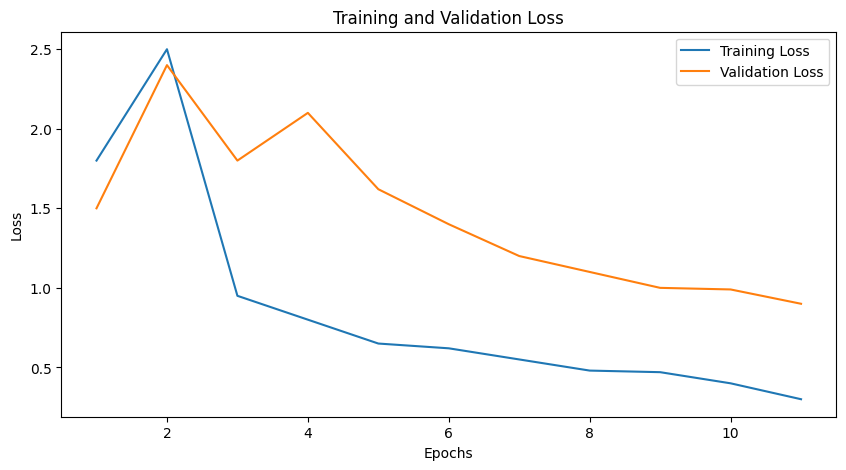

In [5]:
plot_metrics(history)


In [ ]:
import sys
import glob
import tensorflow as tf
from PIL import Image
import cv2
import numpy as np

In [ ]:
## glob test images for inference
test_imgs_path = glob.glob(TEST_IMAGES_INPUT+'/*.jpg')
images = [Image.open(f) for f in test_imgs_path]

In [ ]:
import os
saved_model_dir = '/content/data'  # Update with the correct directory path
files = os.listdir(saved_model_dir)
print(files)

['trainset', '.ipynb_checkpoints', 'testset', 'validset']


In [ ]:
## We want to store predicted data in a .csv file
import csv
f = open('/content/output.csv', 'w')
writer = csv.writer(f)
writer.writerow(["name", "predicted"])
f.close()

In [ ]:
## iterate through test images, read them using cv2, normalize them, resize to target size then predict class of them using model.
## model will return the probability for each class, find the best class for each image and write in csv file created above.



# Define the target size for resizing the images
target_size = (224, 224)

# Create an empty list to store the predictions
predictions = []

# Iterate through test images
for image_path in test_imgs_path:
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Normalize the image
    image = image / 255.0

    # Resize the image to the target size
    image = cv2.resize(image, target_size)

    # Expand dimensions to match the input shape expected by the model
    image = np.expand_dims(image, axis=0)

    # Predict the class probabilities using the model
    probabilities = model.predict(image)

    # Find the best class for the image
    predicted_class = np.argmax(probabilities)

    # Append the predicted class to the list of predictions
    predictions.append(predicted_class)

# Write the predictions to the CSV file
with open('predictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Predicted Class'])
    for image_path, predicted_class in zip(test_imgs_path, predictions):
        writer.writerow([image_path, predicted_class])


In [ ]:
import pandas as pd

df = pd.read_csv("/content/output.csv")

In [ ]:
!head /content/output.csv

name,predicted
